# Processing Notebook

In [16]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Perfect Efficiency: 92.34473875791006%
Actual Efficiency: 79.99663997311978%


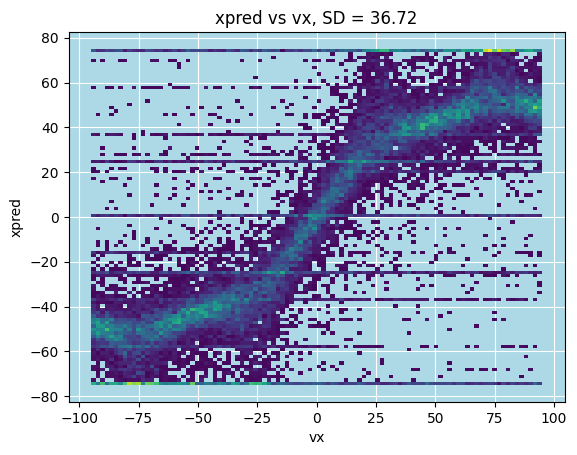

In [24]:
nx,ny = 4,4
n = nx * ny

rep = {-1:0}
sizes = [5]
lens = []
dataframes = {}
for s in sizes:
    df = pd.read_csv(f"neutron5cm_2cmSciFull_CoupledBig.csv")
    df['total'] = np.zeros_like(df['vx']).astype(int)
    original_len = len(df['vx'])
    lens.append(original_len)
    for i in range(n):
        col = f'photons{i}'
        df[col] = df[col].replace(rep)
        df['total'] += df[col]
    df['zpred'] = np.ones_like(df['vx']).astype(float) * s/2
    dataframes[f"{s}Sci"] = df

    print(f'Perfect Efficiency: {sum(df['total'] > 0)/original_len * 100}%')

# Drop rows with no detections
for key in dataframes.keys():
    frame: pd.DataFrame = dataframes[key]
    frame = frame[frame['total'] > 0]
    dataframes[key] = frame

# Drop all rows that are not one detector events and have less than n photons
for key in dataframes.keys():
    tmp = np.zeros_like(dataframes[key]['vx']).astype(int)
    original_len = len(tmp)
    for i in range(nx * ny):
        col = f'photons{i}'
        tmp += dataframes[key][col] > 0

    ONEDETECTION = tmp == 1
    dataframes[key]["ONEDETECTION"] = ONEDETECTION
    
    NOTENOUGH = np.logical_or(ONEDETECTION,dataframes[key]['total'] > 3)
    dataframes[key] = dataframes[key][NOTENOUGH]

for key in dataframes.keys():
    frame = dataframes[key].copy()
    ONE = frame["ONEDETECTION"]
    frame = frame[ONE]
    frame['xpred'] = np.ones_like(frame['vx'])
    frame['ypred'] = np.ones_like(frame['vx'])
    for i in range(nx * ny):
        xmask = frame[f"photons{i}"] > 0
        xpred = frame.loc[:,'xpred'][xmask] * frame.loc[:,f'xpos{i}'][xmask]
        frame['xpred'][xmask] = xpred

        ymask = frame[f"photons{i}"] > 0
        ypred = frame.loc[:,'ypred'][ymask] * frame.loc[:,f'ypos{i}'][ymask]
        frame['ypred'][ymask] = ypred

    dataframes[key]['xpred'] = np.zeros_like(ONE).astype(float)
    dataframes[key]['ypred'] = np.zeros_like(ONE).astype(float)
    dataframes[key]['xpred'][ONE] = frame['xpred']
    dataframes[key]['ypred'][ONE] = frame['ypred']

left_dropnames = [] # Columns to drop to get left subset
right_dropnames = [] # Columns to drop to get right subset
up_dropnames = [] # Columns to drop to get up subset
down_dropnames = [] # Columns to drop to get down subset
nx = 4
ny = 4
num = 0
for i in range(nx):
    for j in range(ny):
        # if i < (nx / 2):
        #     print("left:",num)
        #     right_dropnames.append(f"photons{num}")
        #     right_dropnames.append(f"ypos{num}")
        #     right_dropnames.append(f"xpos{num}")
        # else:
        if not (i < (nx / 2)):
            #print("right:",num)
            left_dropnames.append(f"photons{num}")
            left_dropnames.append(f"ypos{num}")
            left_dropnames.append(f"xpos{num}")

        if j < (ny / 2):
            #print("down:",num)
            up_dropnames.append(f"photons{num}")
            up_dropnames.append(f"ypos{num}")
            up_dropnames.append(f"xpos{num}")
        # else:
        #     print('up:',num)
        #     down_dropnames.append(f"photons{num}")
        #     down_dropnames.append(f"ypos{num}")
        #     down_dropnames.append(f"xpos{num}")

        num += 1

for key in dataframes.keys():
    frame = dataframes[key].copy()
    MORETHAN1 = ~frame['ONEDETECTION']
    frame = frame[MORETHAN1]

    left = frame.drop(left_dropnames,axis=1)
    left['total'] = np.zeros_like(left['vx']).astype(int)
    up = frame.drop(up_dropnames,axis=1)
    up['total'] = np.zeros_like(up['vx']).astype(int)

    for i in range(nx * ny):
        # LEFT
        try:
            left['total'] = left['total'] + left[f"photons{i}"]
        except:
            pass
        # UP
        try:
            up['total'] = up['total'] + up[f'photons{i}']
        except:
            pass

    Lratio = left['total'] / frame['total']
    Uratio = up['total'] / frame['total']

    px = np.poly1d(np.polyfit(x=Lratio,y=left['vx'],deg=3))
    xpred = px(Lratio)

    py = np.poly1d(np.polyfit(x=Uratio,y=up['vy'],deg=3))
    ypred = py(Uratio)

    uniqueX = []
    uniqueY = []
    for i in range(nx * ny):
        # X
        try:
            xcolvals = [val for val in list(set(frame[f'xpos{i}'])) if val != -99.9][0]
            uniqueX.append(xcolvals)
        except:
            pass
        # Y
        try:
           ycolvals = [val for val in list(set(frame[f'ypos{i}'])) if val != -99.9][0]
           uniqueY.append(ycolvals)
        except:
            pass
    xmax = max(uniqueX)
    xmin = min(uniqueX)
    ymax = max(uniqueY)
    ymin = min(uniqueY)

    XABOVEMAX = xpred > xmax
    XBELOWMAX = xpred < xmin
    YABOVEMAX = ypred > ymax
    YBELOWMAX = ypred < ymin

    xpred[XABOVEMAX] = np.ones(sum(XABOVEMAX)) * xmax
    xpred[XBELOWMAX] = np.ones(sum(XBELOWMAX)) * xmin
    ypred[YABOVEMAX] = np.ones(sum(YABOVEMAX)) * ymax
    ypred[YBELOWMAX] = np.ones(sum(YBELOWMAX)) * ymin

    dataframes[key]['xpred'][MORETHAN1] = xpred
    dataframes[key]['ypred'][MORETHAN1] = ypred

for i,key in enumerate(dataframes):
    print(f'Actual Efficiency: {len(dataframes[key]['xpred']) / lens[i] * 100}%')

    x = dataframes[key]["vx"]
    y = dataframes[key]["xpred"]

    fig,ax = plt.subplots(1,1)
    sns.histplot(ax=ax,x=x,y=y,bins=100,cmap='viridis')
    plt.title(f'xpred vs vx, SD = {round(np.std(dataframes[key]['xpred'] - dataframes[key]['vx']),ndigits=2)}')
    ax.set_facecolor('#ADD8E6')
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='white', linestyle='-')
    ax.xaxis.grid(color='white', linestyle='-')

## Standard Deviations


In [25]:
xsds = np.ones(len(dataframes))
ysds = xsds.copy()
zsds = xsds.copy()

for i,key in enumerate(dataframes):
    xhat = dataframes[key]['xpred']
    x = dataframes[key]['vx']

    yhat = dataframes[key]['ypred']
    y = dataframes[key]['vy']

    zhat = dataframes[key]['zpred']
    z = dataframes[key]['vz']

    xsds[i] = np.std(xhat-x)
    ysds[i] = np.std(yhat-y) 
    zsds[i] = np.std(zhat-z)
    print(xsds,ysds,zsds)

[36.72006262] [36.4847498] [5.74826125]


## Ratios

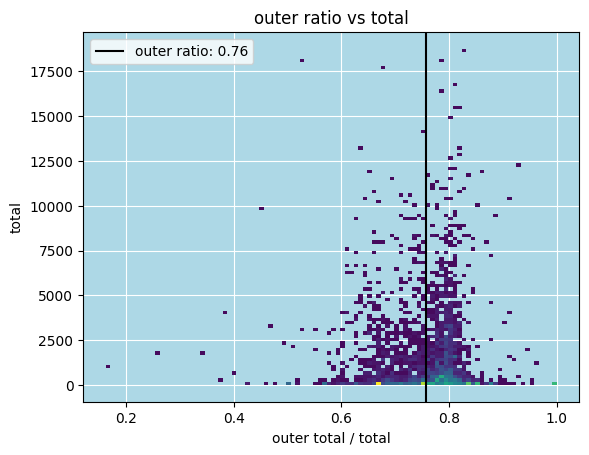

In [26]:
n = 4 * 4
rep = {-1:0}
df = pd.read_csv(f"neutron5cm_2cmSciFull_Coupled.csv")
df['total'] = np.zeros_like(df['vx']).astype(int)
original_len = len(df['vx'])
for i in range(n):
    col = f'photons{i}'
    df[col] = df[col].replace(rep)
    df['total'] += df[col]

#print(f'2cm Sci Perfect Efficiency: {round(sum(df['total'] > 0)/original_len * 100,ndigits=2)}%')

df = df[df['total'] > 5]

left_dropnames = [] # Columns to drop to get left subset
up_dropnames = [] # Columns to drop to get up subset
outer_dropnames = []
nx = 4
ny = 4
num = 0
for i in range(nx):
    for j in range(ny):
        if (i < nx-1) and (i > 0) and (j > 0) and (j < ny-1):
            outer_dropnames.append(f"photons{num}")
            outer_dropnames.append(f"ypos{num}")
            outer_dropnames.append(f"xpos{num}")

        num += 1

outer = df.drop(outer_dropnames,axis=1)
outer['total'] = np.zeros_like(outer['vx'])

for i in range(n):
    try:
        outer['total'] += outer[f'photons{i}']
    except:
        pass

fig,ax = plt.subplots(1,1)
sns.histplot(y=df['total'],x=outer['total']/df['total'],bins=100,cmap='viridis')
plt.axvline(x=np.mean(outer['total']/df['total']),c='black',label=f'outer ratio: {round(np.mean(outer['total']/df['total']),ndigits=2)}')
plt.title('outer ratio vs total')
plt.xlabel('outer total / total')
plt.ylabel('total')
plt.legend()
ax.set_facecolor('#ADD8E6')
ax.set_axisbelow(True)
ax.yaxis.grid(color='white', linestyle='-')
ax.xaxis.grid(color='white', linestyle='-')

plt.savefig('outer_ratio.jpg',dpi=300)


## Method of Weighted Averages

Perfect Efficiency: 92.345%
Actual Efficiency: 73.445%


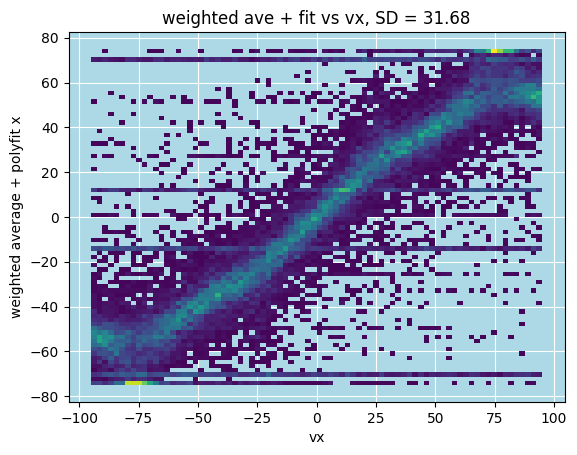

In [56]:
nx,ny = 4,4
n = nx * ny
rep = {-1:0}

df = pd.read_csv('neutron5cm_2cmSciFull_CoupledBig.csv')

numdetections = np.zeros_like(df['vx']).astype(float)
total = numdetections.copy()
original_len = len(df['vx'])

for i in range(n):
    df[f'photons{i}'] = df[f'photons{i}'].replace(rep)
    numdetections += df[f'photons{i}'] > 0
    total += df[f'photons{i}']

print(f'Perfect Efficiency: {round(100 * sum(total > 0) / original_len, ndigits=3)}%')

BADDATA = np.logical_or(numdetections == 1,total > 5)
df = df[BADDATA]

print(f'Actual Efficiency: {round(100 * sum(BADDATA) / original_len, ndigits=3)}%')

total = np.zeros_like(df['vx']).astype(float)
for i in range(n):
    total += df[f'photons{i}']

df['total'] = total

xweight = np.zeros_like(df['vx']).astype(float)
yweight = xweight.copy()
numdetections = xweight.copy()
for i in range(n):
    weight = df[f'photons{i}'] / df['total']
    xweight += weight * df[f'xpos{i}']
    yweight += weight * df[f'ypos{i}']
    numdetections += df[f'photons{i}'] > 0
ONEDETECTION = numdetections == 1

px = np.poly1d(np.polyfit(xweight,df['vx'],deg=3))
py = np.poly1d(np.polyfit(yweight,df['vy'],deg=3))
xpred = px(xweight)
ypred = py(yweight)

# Perform corrections to any predicted values that are outside of the range of the detector
uniqueX = []
uniqueY = []
for i in range(nx * ny):
    # X
    try:
        xcolvals = [val for val in list(set(df[f'xpos{i}'])) if val != -99.9][0]
        uniqueX.append(xcolvals)
    except:
        pass
    # Y
    try:
        ycolvals = [val for val in list(set(df[f'ypos{i}'])) if val != -99.9][0]
        uniqueY.append(ycolvals)
    except:
        pass
xmax = max(uniqueX)
xmin = min(uniqueX)
ymax = max(uniqueY)
ymin = min(uniqueY)

XABOVEMAX = xpred > xmax
XBELOWMAX = xpred < xmin
YABOVEMAX = ypred > ymax
YBELOWMAX = ypred < ymin

xpred[XABOVEMAX] = np.ones(sum(XABOVEMAX)) * xmax
xpred[XBELOWMAX] = np.ones(sum(XBELOWMAX)) * xmin
ypred[YABOVEMAX] = np.ones(sum(YABOVEMAX)) * ymax
ypred[YBELOWMAX] = np.ones(sum(YBELOWMAX)) * ymin

fig,ax = plt.subplots(1,1)
sns.histplot(ax=ax,x=df['vx'],y=xpred,bins=80,cmap='viridis')
ax.set_title(f'weighted ave + fit vs vx, SD = {round(np.std(xpred-df["vx"]),ndigits=2)}')
ax.set_ylabel('weighted average + polyfit x')
ax.set_xlabel('vx')
ax.set_facecolor('#ADD8E6')
ax.set_axisbelow(True)
ax.yaxis.grid(color='white', linestyle='-')
ax.xaxis.grid(color='white', linestyle='-')

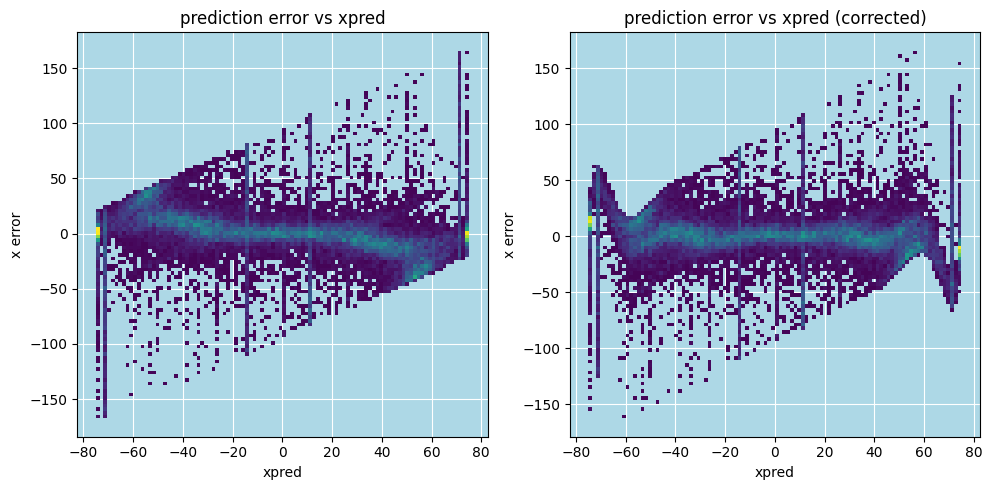

In [154]:
xerror = xpred-df['vx']#[~ONEDETECTION]
x_correction = np.poly1d(np.polyfit(xpred,xerror,deg=12))

xin = np.linspace(-75,75,200)
xout = x_correction(xin)

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))

sns.histplot(ax=ax[0],x=xpred,y=xerror,bins=100,cmap='viridis')
ax[0].set_title(f'prediction error vs xpred')
ax[0].set_ylabel('x error')
ax[0].set_xlabel('xpred')
ax[0].set_facecolor('#ADD8E6')
ax[0].set_axisbelow(True)
ax[0].yaxis.grid(color='white', linestyle='-')
ax[0].xaxis.grid(color='white', linestyle='-')

sns.histplot(ax=ax[1],x=xpred,y=xpred-x_correction(xpred)-df['vx'],bins=100,cmap='viridis')
ax[1].set_title(f'prediction error vs xpred (corrected)')
ax[1].set_ylabel('x error')
ax[1].set_xlabel('xpred')
ax[1].set_facecolor('#ADD8E6')
ax[1].set_axisbelow(True)
ax[1].yaxis.grid(color='white', linestyle='-')
ax[1].xaxis.grid(color='white', linestyle='-')

plt.tight_layout()

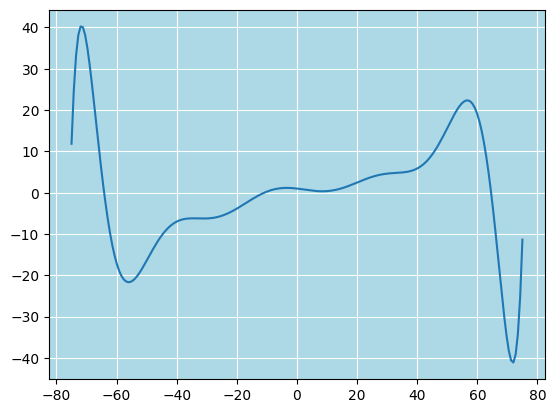

In [155]:
fig,ax = plt.subplots(1,1)
sns.lineplot(ax=ax,x=xin,y=-xout)
ax.set_facecolor('#ADD8E6')
ax.set_axisbelow(True)
ax.yaxis.grid(color='white', linestyle='-')
ax.xaxis.grid(color='white', linestyle='-')

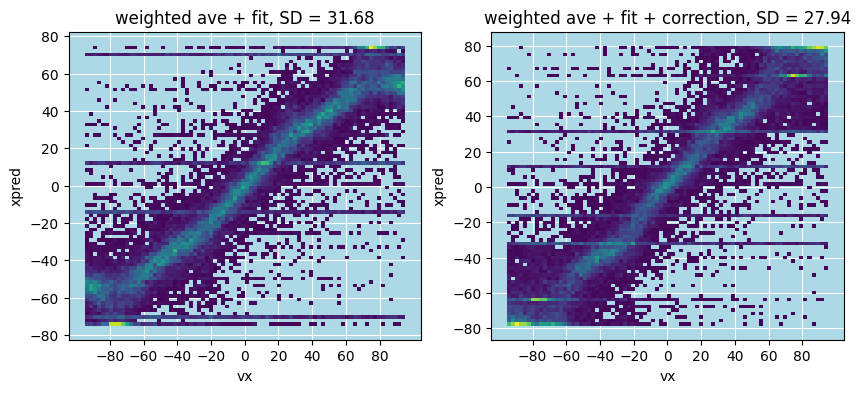

In [156]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,4))
sns.histplot(ax=ax[0],x=df['vx'],y=xpred,bins=80,cmap='viridis')
ax[0].set_title(f'weighted ave + fit, SD = {round(np.std(xpred-df["vx"]),ndigits=2)}')

sns.histplot(ax=ax[1],x=df['vx'],y=xpred-x_correction(xpred),bins=80,cmap='viridis')
ax[1].set_title(f'weighted ave + fit + correction, SD = {round(np.std(xpred-x_correction(xpred)-df["vx"]),ndigits=2)}')

for i,_ in enumerate(ax):
    ax[i].set_xticks([-80,-60,-40,-20,0,20,40,60,80])
    ax[i].set_yticks([-80,-60,-40,-20,0,20,40,60,80])
    ax[i].set_ylabel('xpred')
    ax[i].set_xlabel('vx')
    ax[i].set_facecolor('#ADD8E6')
    ax[i].set_axisbelow(True)
    ax[i].yaxis.grid(color='white', linestyle='-')
    ax[i].xaxis.grid(color='white', linestyle='-')